In [1]:


import pandas as pd
import numpy as np
import scipy as sp
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import prophet
from sklearn.model_selection import train_test_split

<h1 style="text-align:center">1 Descriptive Data Analysis</h1>

<h2 style="text-align:left">1.1 Overview</h2>

American Electric Power Company is a major electric utility in the US, which serves more then 5 million customers in regions near Ohio and Texas. The dataset used in this analysis report includes data of electric use by AEP customers from 2004 to 2018.

In [2]:
MasterData=pd.read_csv('AEP_hourly.csv')
MasterData.head(5)#Check the structure of the dataset


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [3]:
null_counts = MasterData.isnull().sum()
print(null_counts)#Identify any null values

Datetime    0
AEP_MW      0
dtype: int64


In [4]:
MasterData['Datetime'] = pd.to_datetime (MasterData['Datetime'], yearfirst=True) #converting text to daytime

<AxesSubplot: xlabel='Datetime'>

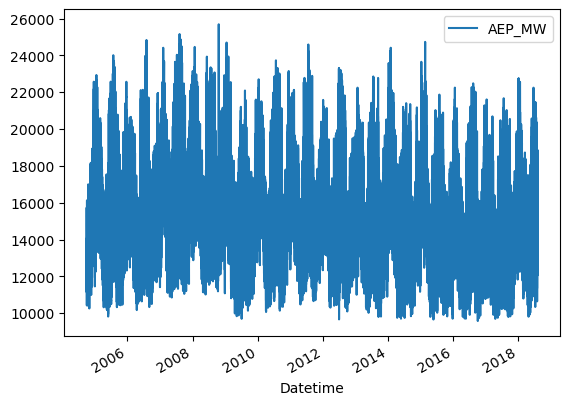

In [5]:
MasterData.plot(kind='line',x='Datetime',y='AEP_MW')

When the general data is plotted, it is hard to see any trend since the fluctuation is too large, so that processing is necessery

<h2 style="text-align:left">1.2 Data processing</h2>

<AxesSubplot: xlabel='Datetime'>

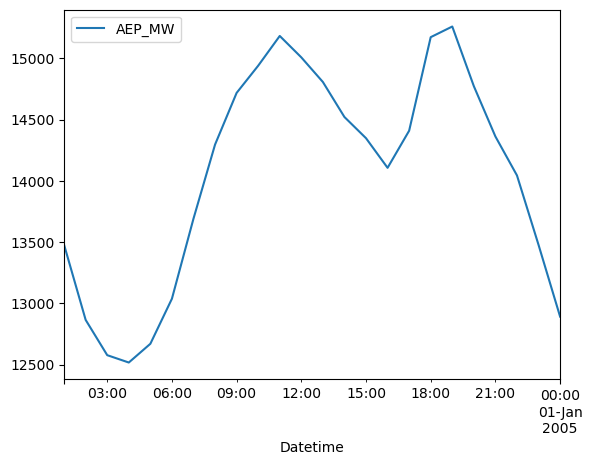

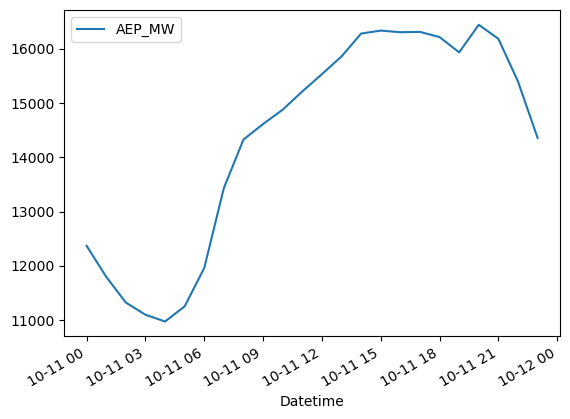

In [6]:
sample=MasterData.head(24)
sample.plot(kind='line',x='Datetime',y='AEP_MW')
sample2=MasterData[MasterData['Datetime'].dt.date==datetime.date(2010,10,11)]
sample2.plot(kind='line',x='Datetime',y='AEP_MW')

As an example, a random pick of data shows that throughout a day the usage of power follows a similliar pattern with the valley lies on ~04:00 and two similliar peaks. However, those two sets of data still inherited a significance difference, which is possibly associated with its month, if it is weekday, and its year. Notice that 2010 Oct 11th is a weekday and 2005 Jan 1st is a public holiday. So, the datetime of this dataset is seperated into year, month, date, time and weekday to discover the influence of those parameters on electricity use. 

In [7]:
MasterData['Year']=MasterData['Datetime'].dt.year
MasterData['Month']=MasterData['Datetime'].dt.month
MasterData['Day']=MasterData['Datetime'].dt.day
MasterData['Date']=MasterData['Datetime'].dt.date
MasterData['Time']=MasterData['Datetime'].dt.time
MasterData['Weekday']=MasterData['Datetime'].dt.weekday#Seperate parameters

MasterData.head()


,Datetime,AEP_MW,Year,Month,Day,Date,Time,Weekday
0,2004-12-31 01:00:00,13478.0,2004,12,31,2004-12-31,01:00:00,4
1,2004-12-31 02:00:00,12865.0,2004,12,31,2004-12-31,02:00:00,4
2,2004-12-31 03:00:00,12577.0,2004,12,31,2004-12-31,03:00:00,4
3,2004-12-31 04:00:00,12517.0,2004,12,31,2004-12-31,04:00:00,4
4,2004-12-31 05:00:00,12670.0,2004,12,31,2004-12-31,05:00:00,4


<h2 style="text-align:left">1.3 Description</h2>

<AxesSubplot: xlabel='Year'>

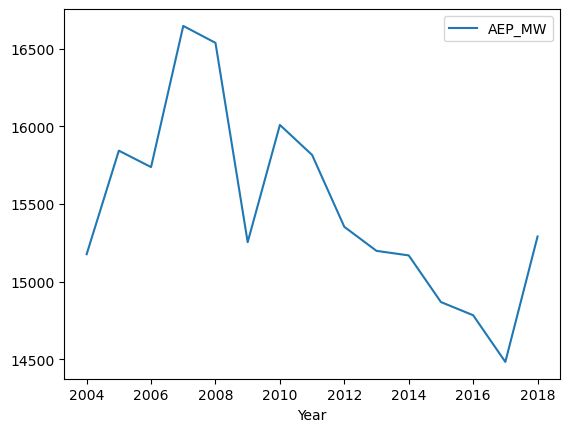

In [8]:
DataYear=MasterData.groupby(by='Year').mean()
DataYear.plot(kind='line',y='AEP_MW')

Taking the average hourly electricity usage from each year, it is visible that the electricity usage peaks at 2007 and a valley occurs at 2009, while a trend of declining presents between 2010 and 2017. 

<AxesSubplot: xlabel='Month'>

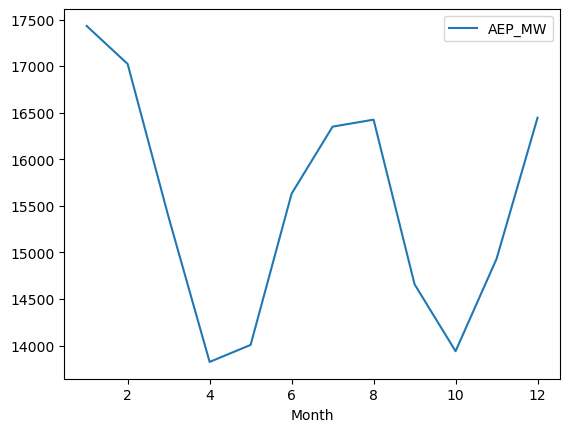

In [9]:
DataMonth=MasterData.groupby(by='Month').mean()
DataMonth.plot(kind='line',y='AEP_MW')

Taking the average electricity usage from each month, appearantly that the electricity usage peaks at winters and summers, while valleys in springs and falls

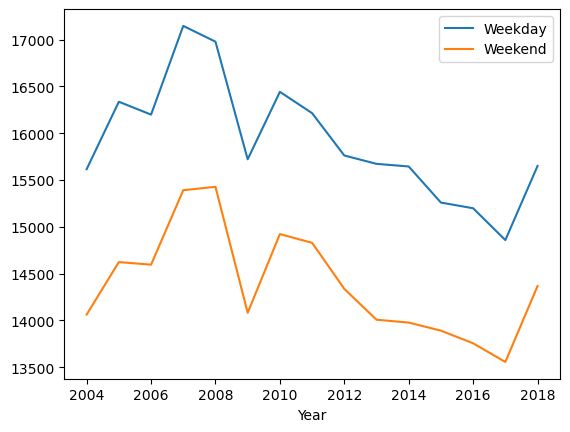

In [10]:
DataWeekday=MasterData[MasterData['Weekday']<5]
DataWeekEnd=MasterData[MasterData['Weekday']>4]
DataYearWD=DataWeekday.groupby(by='Year').mean()
DataYearWE=DataWeekEnd.groupby(by='Year').mean()
ax=DataYearWD.plot(kind='line',y='AEP_MW',label='Weekday')
DataYearWE.plot(kind='line',y='AEP_MW',label='Weekend',ax=ax)
plt.show()


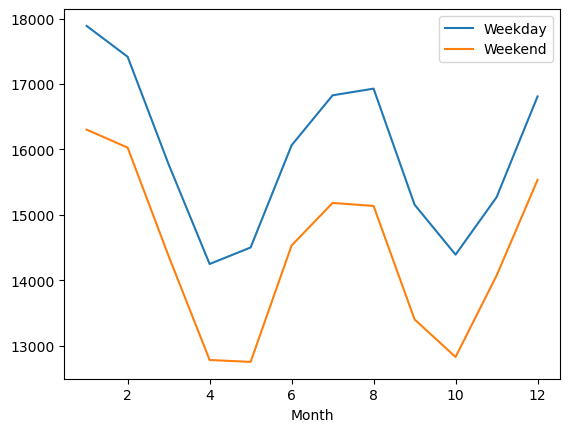

In [11]:
WeekGraph=DataWeekday.groupby(by='Month').mean()
WeekEndGraph=DataWeekEnd.groupby(by='Month').mean()
ax=WeekGraph.plot(kind='line',y='AEP_MW',label='Weekday')
WeekEndGraph.plot(kind='line',y='AEP_MW',label='Weekend',ax=ax)
plt.show()

Consider that the electricity using pattern is likely to differ between weekdays and weekends, the two graphes above are seperated into weekday and weekend parts, showing that same trend are followed both by weekday data and weekend data, while electricity use is significantly lower on weekends

<AxesSubplot: xlabel='Time'>

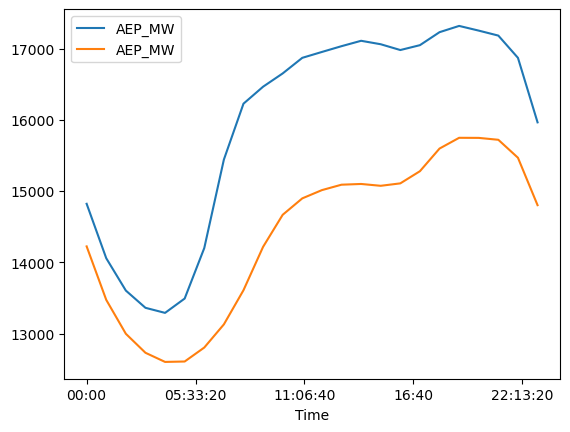

In [12]:
WeekGraphT=DataWeekday.groupby(by='Time').mean()
ax=WeekGraphT.plot(kind='line',y='AEP_MW')
WeekEndGraphT=DataWeekEnd.groupby(by='Time').mean()
WeekEndGraphT.plot(kind='line',y='AEP_MW',ax=ax)

The average electricity use of weekdays and weekends are plotted above, visible that with similliat trend, weekend electricity use has a generally lower level together with a lower day-night difference 

<AxesSubplot: xlabel='Month'>

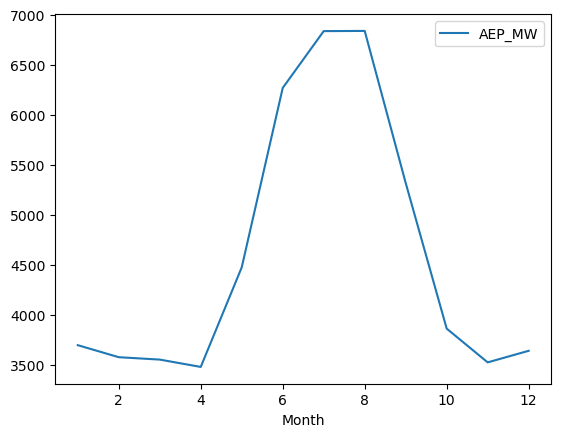

In [13]:
DAYNIGHTDIFF=MasterData.groupby(by='Date').agg({'AEP_MW':np.ptp})
DAYNIGHTDIFF.reset_index(inplace=True)
DAYNIGHTDIFF['Date'] = pd.to_datetime (DAYNIGHTDIFF['Date'], yearfirst=True) 
DAYNIGHTDIFF['Month']=DAYNIGHTDIFF['Date'].dt.month
DAYNIGHTDIFFMTH=DAYNIGHTDIFF.groupby(by='Month').mean()
DAYNIGHTDIFFMTH.plot(kind='line',y='AEP_MW')

In the graph above, the day-night difference across a year is plotted above, showing the day-night difference of electricity use peaks at summers while valleys at winters.

<AxesSubplot: xlabel='Month'>

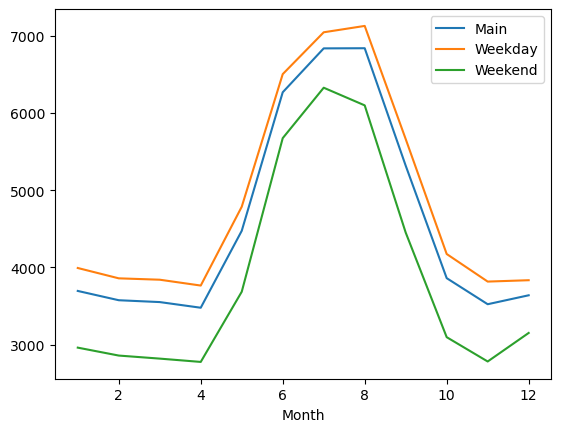

In [14]:
DAYNIGHTDIFFwd=DataWeekday.groupby(by='Date').agg({'AEP_MW':np.ptp})
DAYNIGHTDIFFwd.reset_index(inplace=True)
DAYNIGHTDIFFwd['Date'] = pd.to_datetime (DAYNIGHTDIFFwd['Date'], yearfirst=True) 
DAYNIGHTDIFFwd['Month']=DAYNIGHTDIFFwd['Date'].dt.month
DAYNIGHTDIFFMTHwd=DAYNIGHTDIFFwd.groupby(by='Month').mean()

DAYNIGHTDIFFwe=DataWeekEnd.groupby(by='Date').agg({'AEP_MW':np.ptp})
DAYNIGHTDIFFwe.reset_index(inplace=True)
DAYNIGHTDIFFwe['Date'] = pd.to_datetime (DAYNIGHTDIFFwe['Date'], yearfirst=True) 
DAYNIGHTDIFFwe['Month']=DAYNIGHTDIFFwe['Date'].dt.month
DAYNIGHTDIFFMTHwe=DAYNIGHTDIFFwe.groupby(by='Month').mean()

ax=DAYNIGHTDIFFMTH.plot(kind='line',y='AEP_MW',label='Main')
DAYNIGHTDIFFMTHwd.plot(kind='line',y='AEP_MW',ax=ax,label='Weekday')
DAYNIGHTDIFFMTHwe.plot(kind='line',y='AEP_MW',ax=ax,label='Weekend')

To verify the influence of weekdays and weekends on such pattern, data from weekdays and weekends are seperately plotted, which shows that even though weekdays tend to have a larger day-night difference, the pattern of peaking in summer and vallying in winter applys for both weekdays and weekends.

In [15]:
DataWin=MasterData[(MasterData['Month']<3)|(MasterData['Month']>11)]
DataSpr=MasterData[(MasterData['Month']>2)&(MasterData['Month']<6)]
DataSum=MasterData[(MasterData['Month']>5)&(MasterData['Month']<9)]
DataAut=MasterData[(MasterData['Month']>8)&(MasterData['Month']<12)]#Seperating data from four seasons


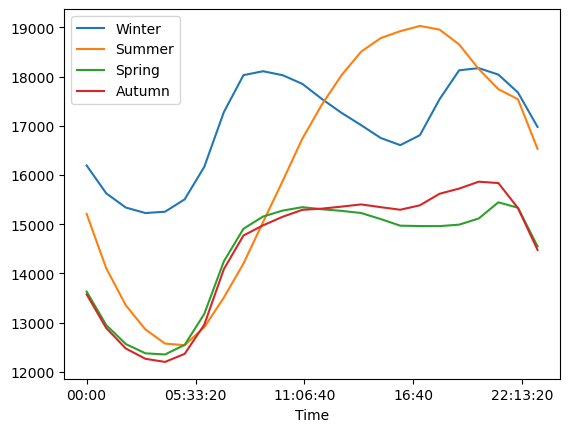

In [16]:
WinGraphT=DataWin.groupby(by='Time').mean()
SumGraphT=DataSum.groupby(by='Time').mean()
SprGraphT=DataSpr.groupby(by='Time').mean()
AutGraphT=DataAut.groupby(by='Time').mean()
ax=WinGraphT.plot(kind='line',y='AEP_MW',label='Winter')
SumGraphT.plot(kind='line',y='AEP_MW',ax=ax,label='Summer')
SprGraphT.plot(kind='line',y='AEP_MW',ax=ax,label='Spring')
AutGraphT.plot(kind='line',y='AEP_MW',ax=ax,label='Autumn')
plt.show()


Average hourly electricity use from the four seasons are plotted above, it is visible that the electricity using pattern are similliar in autumns and springs. In summer, the electricity use has a similliar valley value comparing to autumns and springs, ans a single peak at afternoon. Electricity usage in winter has a valley value significantly larger then all others, and has two peaks on morning and evening. Such difference in pattern is due to use of heating devices and air conditioning, according to EIA.gov.

<AxesSubplot: xlabel='Time'>

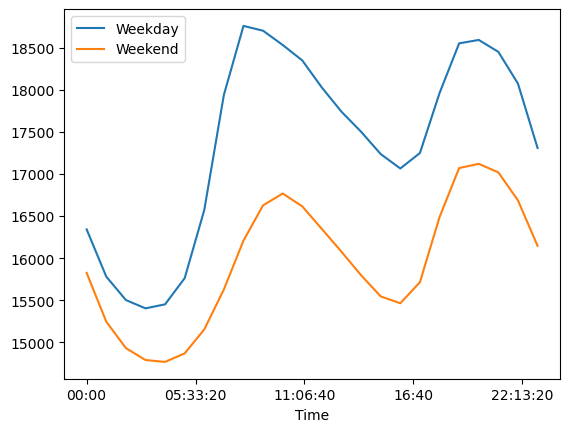

In [17]:
DataWinWD=DataWeekday[(DataWeekday['Month']<3)|(DataWeekday['Month']>11)]
DataWinWE=DataWeekEnd[(DataWeekEnd['Month']<3)|(DataWeekEnd['Month']>11)]
WinTWD=DataWinWD.groupby(by='Time').mean()
WinTWE=DataWinWE.groupby(by='Time').mean()
ax=WinTWD.plot(kind='line',y='AEP_MW',label='Weekday')
WinTWE.plot(kind='line',y='AEP_MW',ax=ax,label='Weekend')

Plotting weekday average hourly use and weekend hourly use data from winters shows that the double-peak pattern exists in both weekends and weekdays, shows that such pattern is likely to be mainly caused by non-workplace use of power, which agrees with the statement of EIA.gov.

<h1 style="text-align:center">2 Model Training</h1>

<h2 style="text-align:left">2.1 Prophet</h2>

Since the electricity use shows a repeating manner based on time, the prophet algorism can be used to predict the electricity use based on previous data.

In [18]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [19]:
Trainset1=pd.DataFrame()
Trainset1['ds']=MasterData[MasterData['Year']!=2018]['Datetime']
Trainset1['y']=MasterData[MasterData['Year']!=2018]['AEP_MW']
Testset1=pd.DataFrame()
Testset1['ds']=MasterData[MasterData['Year']==2018]['Datetime']

The dataset is splitted into train set and test set, data from 2018 is used for training while data from other years are used for testing.

In [20]:
modelProphet1 = Prophet()
modelProphet1.fit(Trainset1)

05:23:01 - cmdstanpy - INFO - Chain [1] start processing
05:24:42 - cmdstanpy - INFO - Chain [1] done processing


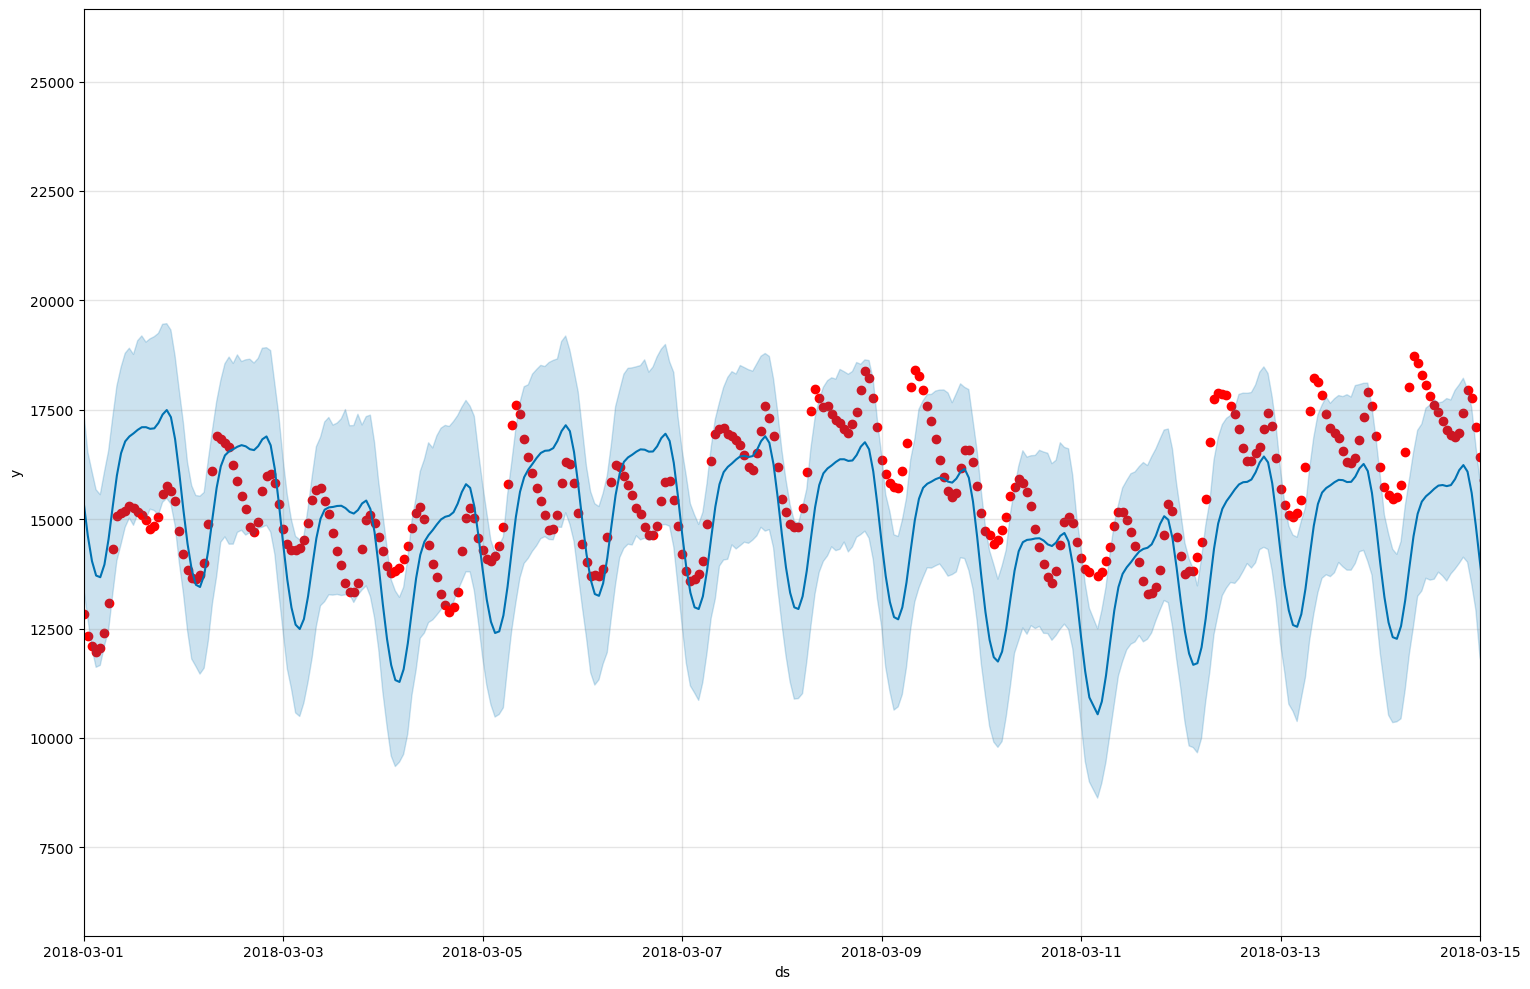

MAE of prophet 1712.5581793760166
MSE of prophet 4811689.200946021


In [21]:
Testset1y=MasterData[MasterData['Year']==2018]['AEP_MW']
Testing1=modelProphet1.predict(Testset1)
y_true1=MasterData[MasterData['Year']==2018]['AEP_MW'].values
y_predict1=Testing1['yhat'].values
mae1 = mean_absolute_error(y_true1, y_predict1)
mse1=mean_squared_error(y_true1, y_predict1)
fig,ax= plt.subplots(figsize=(15,10))
ax.scatter(Testset1['ds'], Testset1y,color='r')
fig= modelProphet1.plot(Testing1,ax=ax)
ax.set_xlim([pd.to_datetime('2018-03-01', format = '%Y-%m-%d'),
             pd.to_datetime('2018-03-15', format = '%Y-%m-%d')])
plt.show()
print('MAE of prophet',mae1)
print('MSE of prophet',mse1)

When performing prediction, the prophet model successfully followed the general trend. however, unneglectable difference between actual electricity usage and the prediction of the model is still present. Despite the difference, most of the datapoints still lies in the error bars of prophet model predictions, which suggest that such model is still useable as a reference when predictiong future electricity use.

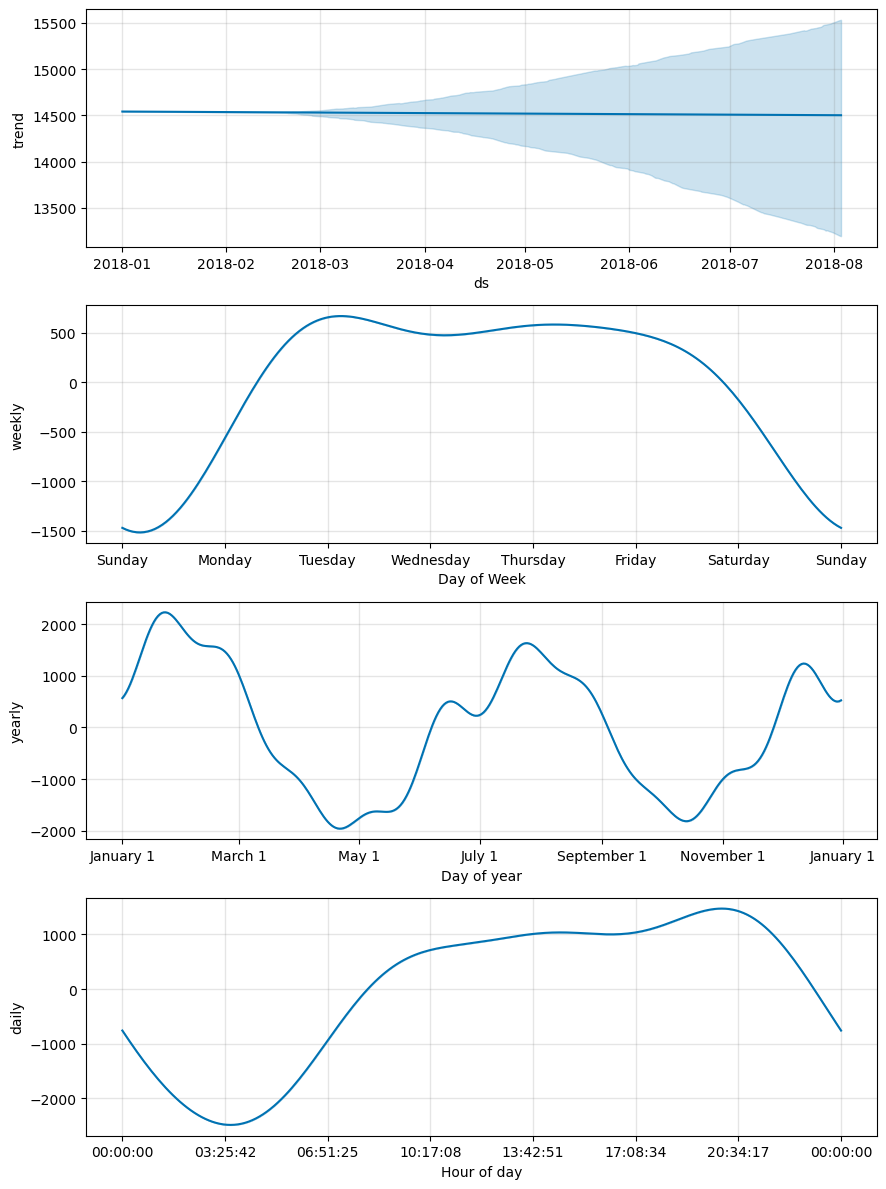

In [22]:
fig= modelProphet1.plot_components(Testing1)
plt.show()

The Prophet model successfully illustrated the pattern of electricity use including the difference in weekday and weekend electricity usage, the usage pattern during different time in a day, and different days in a year. As a comparison, the random forest regressor algorism is used to generate an alternate model with the same training and testing set as the previous one.

<h2 style="text-align:left">2.2 Random Forest Regression</h2>

As a comparison, an alternate model using random forest algorism is trained to evaluate the performance of prophet model.

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
RFtrain=MasterData[MasterData['Year']!=2018][['AEP_MW','Year','Month','Day','Time','Weekday']]
RFtest=MasterData[MasterData['Year']==2018][['AEP_MW','Year','Month','Day','Time','Weekday']]
RFtrain['Time']=RFtrain['Time'].apply(lambda x: x.strftime("%H"))
RFtrain[['Time']]=RFtrain[['Time']].astype(int)
RFtest['Time']=RFtest['Time'].apply(lambda x: x.strftime("%H"))
RFtest['Time']=RFtest['Time'].astype(int)
Input=[('scale',StandardScaler()),('mode',RandomForestRegressor())]
pipe=Pipeline(Input)
pipe.fit(RFtrain[['Year','Month','Day','Time','Weekday']],RFtrain['AEP_MW'])
yhattest=pipe.predict(RFtest[['Year','Month','Day','Time','Weekday']])

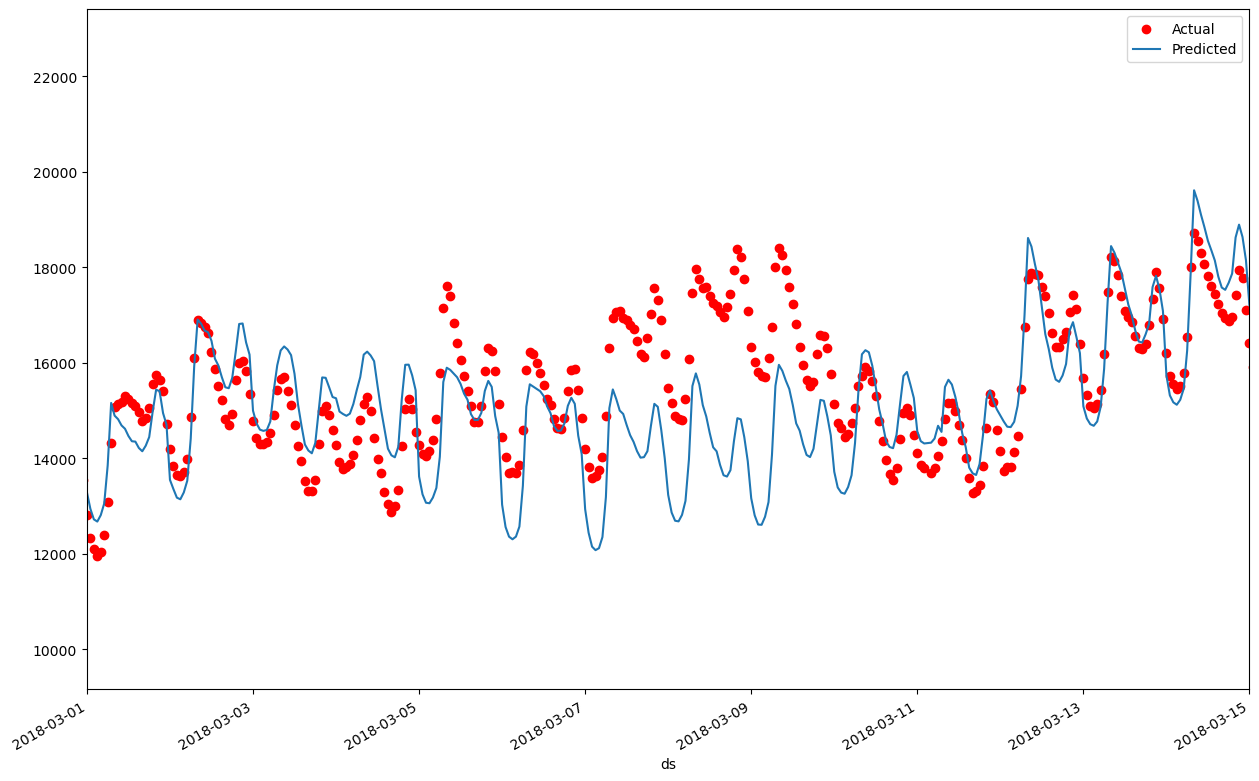

MAE of random forest regression 1411.1292367601245
MSE of random forest regression 3613935.624202025


In [26]:
y_true2=RFtest['AEP_MW'].values
y_predict2=yhattest
predictresult2=pd.DataFrame()
predictresult2['ds']=MasterData[MasterData['Year']==2018]['Datetime']
predictresult2['y']=yhattest
mae2 = mean_absolute_error(y_true2, y_predict2)
mse2=mean_squared_error(y_true2, y_predict2)
fig,ax=plt.subplots(figsize=(15,10))
ax.scatter(Testset1['ds'],y_true2, label='Actual',color='r')
fig=predictresult2.plot(kind='line',x='ds',y='y',label='Predicted',ax=ax)
ax.set_xlim([pd.to_datetime('2018-03-01', format = '%Y-%m-%d'),
             pd.to_datetime('2018-03-15', format = '%Y-%m-%d')])
plt.legend()
plt.show()
print('MAE of random forest regression',mae2)
print('MSE of random forest regression',mse2)

Insterstingly, if solely judge the average value, random forest regression actually performs bettern then prophet. However, the prophet model appears to perform better on obtaining the regularity of electricity use